In [8]:
import pandas as pd
from torch.utils.data import DataLoader, Subset
from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms
from sklearn.model_selection import train_test_split
import zipfile
import os
from torch.utils.data import ConcatDataset
import numpy as np
import torch as torch

# Extra info for logging
extra = 'change to freeze all layers + dropout 0.5 + unfreeze batchnorm + cropped images + track both best val_loss and val_acc + add original image + test image not cropped + add augmented_more dataset + no crop augmented data'

# Load the metadata
metadata = pd.read_csv('meta_data.csv')
metadata['augmented_images_more'] = metadata['augmented_image_name'].str.replace('augmented_images','augmented_images_more')
metadata['augmented_image_nocrop_name'] = metadata['augmented_image_name'].str.replace('augmented_images','augmented_images_nocrop')

# Create a dictionary mapping from image file name to is_training_image

# Only add training images for augmented
temp = metadata[metadata.is_training_image == 1]

is_training_image = dict(zip(temp.augmented_image_name, temp.is_training_image))   # original augmentation
is_training_image.update(zip(temp.augmented_images_more, temp.is_training_image))  # more augmentation
is_training_image.update(zip(temp.augmented_image_nocrop_name, temp.is_training_image)) # augmented but no crop to bbox

# Add original data
# Test will be from original images (not cropped, only resize to 224,224)
is_training_image.update(zip(metadata.image_name, metadata.is_training_image))

# Define the transformation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Function to load or extract dataset
def load_or_extract(directory, zip_file):
    if os.path.isdir(directory):
        print(f"Directory {directory} exists, skipping zip extraction.")
    else:
        print(f"Directory {directory} does not exist, extracting zip file {zip_file}...")
        with zipfile.ZipFile(zip_file, 'r') as zip_ref:
            zip_ref.extractall("./")
        print(f"Extracted {zip_file}.")

# Load or extract both datasets
load_or_extract("../augmented_images", "../augmented_images.zip")
load_or_extract("../CUB_200_2011/images", "../CUB_200_2011/images.zip")
load_or_extract("../augmented_images_more","../augmented_images_more.zip")
load_or_extract("../augmented_images_nocrop","../augmented_images_nocrop.zip")

# Load datasets
dataset_augmented = ImageFolder("../augmented_images", transform=transform)
dataset_images = ImageFolder("../CUB_200_2011/images", transform=transform)
dataset_augmented_more = ImageFolder("../augmented_images_more", transform=transform)
dataset_augmented_nocrop = ImageFolder("../augmented_images_nocrop", transform=transform)


# Combine datasets
all_classes = sorted(set(dataset_images.classes + dataset_augmented.classes + dataset_augmented_more.classes + dataset_augmented_nocrop.classes))
combined_dataset = ConcatDataset([dataset_images, dataset_augmented, dataset_augmented_more, dataset_augmented_nocrop])
combined_dataset.classes = all_classes

print("Loading test indices...")
test_indices = np.load('./efficient_net_best/test_indices.npy')

# Create subset datasets
test_dataset = Subset(combined_dataset, test_indices)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print("Test set size: ", len(test_dataset))

Directory ../augmented_images exists, skipping zip extraction.
Directory ../CUB_200_2011/images exists, skipping zip extraction.
Directory ../augmented_images_more exists, skipping zip extraction.
Directory ../augmented_images_nocrop exists, skipping zip extraction.
Loading test indices...
Test set size:  4634


In [9]:

MODEL1_PATH = './efficient_net_best/efficientnet_b0.pth'
# MODEL2_PATH = 'googlenet.pth'
# MODEL3_PATH = 'mobilenet.pth'

In [10]:
import torch
from torch import nn
from torchvision.models import efficientnet_b0
import torch.nn.functional as F

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class BaseModel(nn.Module):
    def __init__(self):
        super(BaseModel, self).__init__()

    def training_step(self, batch):
        raise NotImplementedError

    def validation_step(self, batch):
        raise NotImplementedError

    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss']))

class EfficientNetModel(BaseModel):
    def __init__(self, num_classes):
        super().__init__()
        self.network = efficientnet_b0(pretrained=True)

        # Add custom layers
        self.network.classifier = nn.Sequential(
            nn.Dropout(0.4),
            nn.Linear(1280, num_classes)
        )


    def forward(self, xb):
        return self.network(xb)

    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def freeze(self):
        # Freeze all the parameters of the model
        for param in self.network.parameters():
            param.requires_grad = False

        # Unfreeze the last layers
        for param in list(self.network.parameters())[0:-2]:
            param.requires_grad = True

    def unfreeze(self):
        # Unfreeze all parameters of the model
        for param in self.network.parameters():
            param.requires_grad = True
            
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = len(combined_dataset.classes)
model1 = torch.load(MODEL1_PATH, map_location=device)
model1.eval()

EfficientNetModel(
  (network): EfficientNet(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
              (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (activation): SiLU(inplace=True)
              (s

In [11]:
def test_model(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print('Test Accuracy of the model on the test images: {} %'.format(100 * correct / total))

test_model(model1, test_loader, device)

Test Accuracy of the model on the test images: 90.50496331463098 %


In [12]:
from sklearn.metrics import classification_report, confusion_matrix

predictions = []
true_labels = []
with torch.no_grad():  # No need to track gradients
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model1(inputs)
        _, preds = torch.max(outputs.data, 1)
        predictions.extend(preds.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

print(classification_report(true_labels, predictions))
print(confusion_matrix(true_labels, predictions))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96        22
           1       1.00      1.00      1.00        25
           2       0.95      0.95      0.95        20
           3       0.83      0.95      0.89        21
           4       1.00      1.00      1.00        11
           5       0.82      1.00      0.90         9
           6       1.00      0.94      0.97        18
           7       0.86      1.00      0.92        12
           8       0.76      0.83      0.79        23
           9       0.96      0.96      0.96        23
          10       0.86      0.86      0.86        22
          11       0.89      1.00      0.94        17
          12       0.96      0.92      0.94        26
          13       1.00      0.95      0.98        22
          14       0.96      1.00      0.98        23
          15       1.00      0.96      0.98        24
          16       1.00      1.00      1.00        18
          17       0.90    

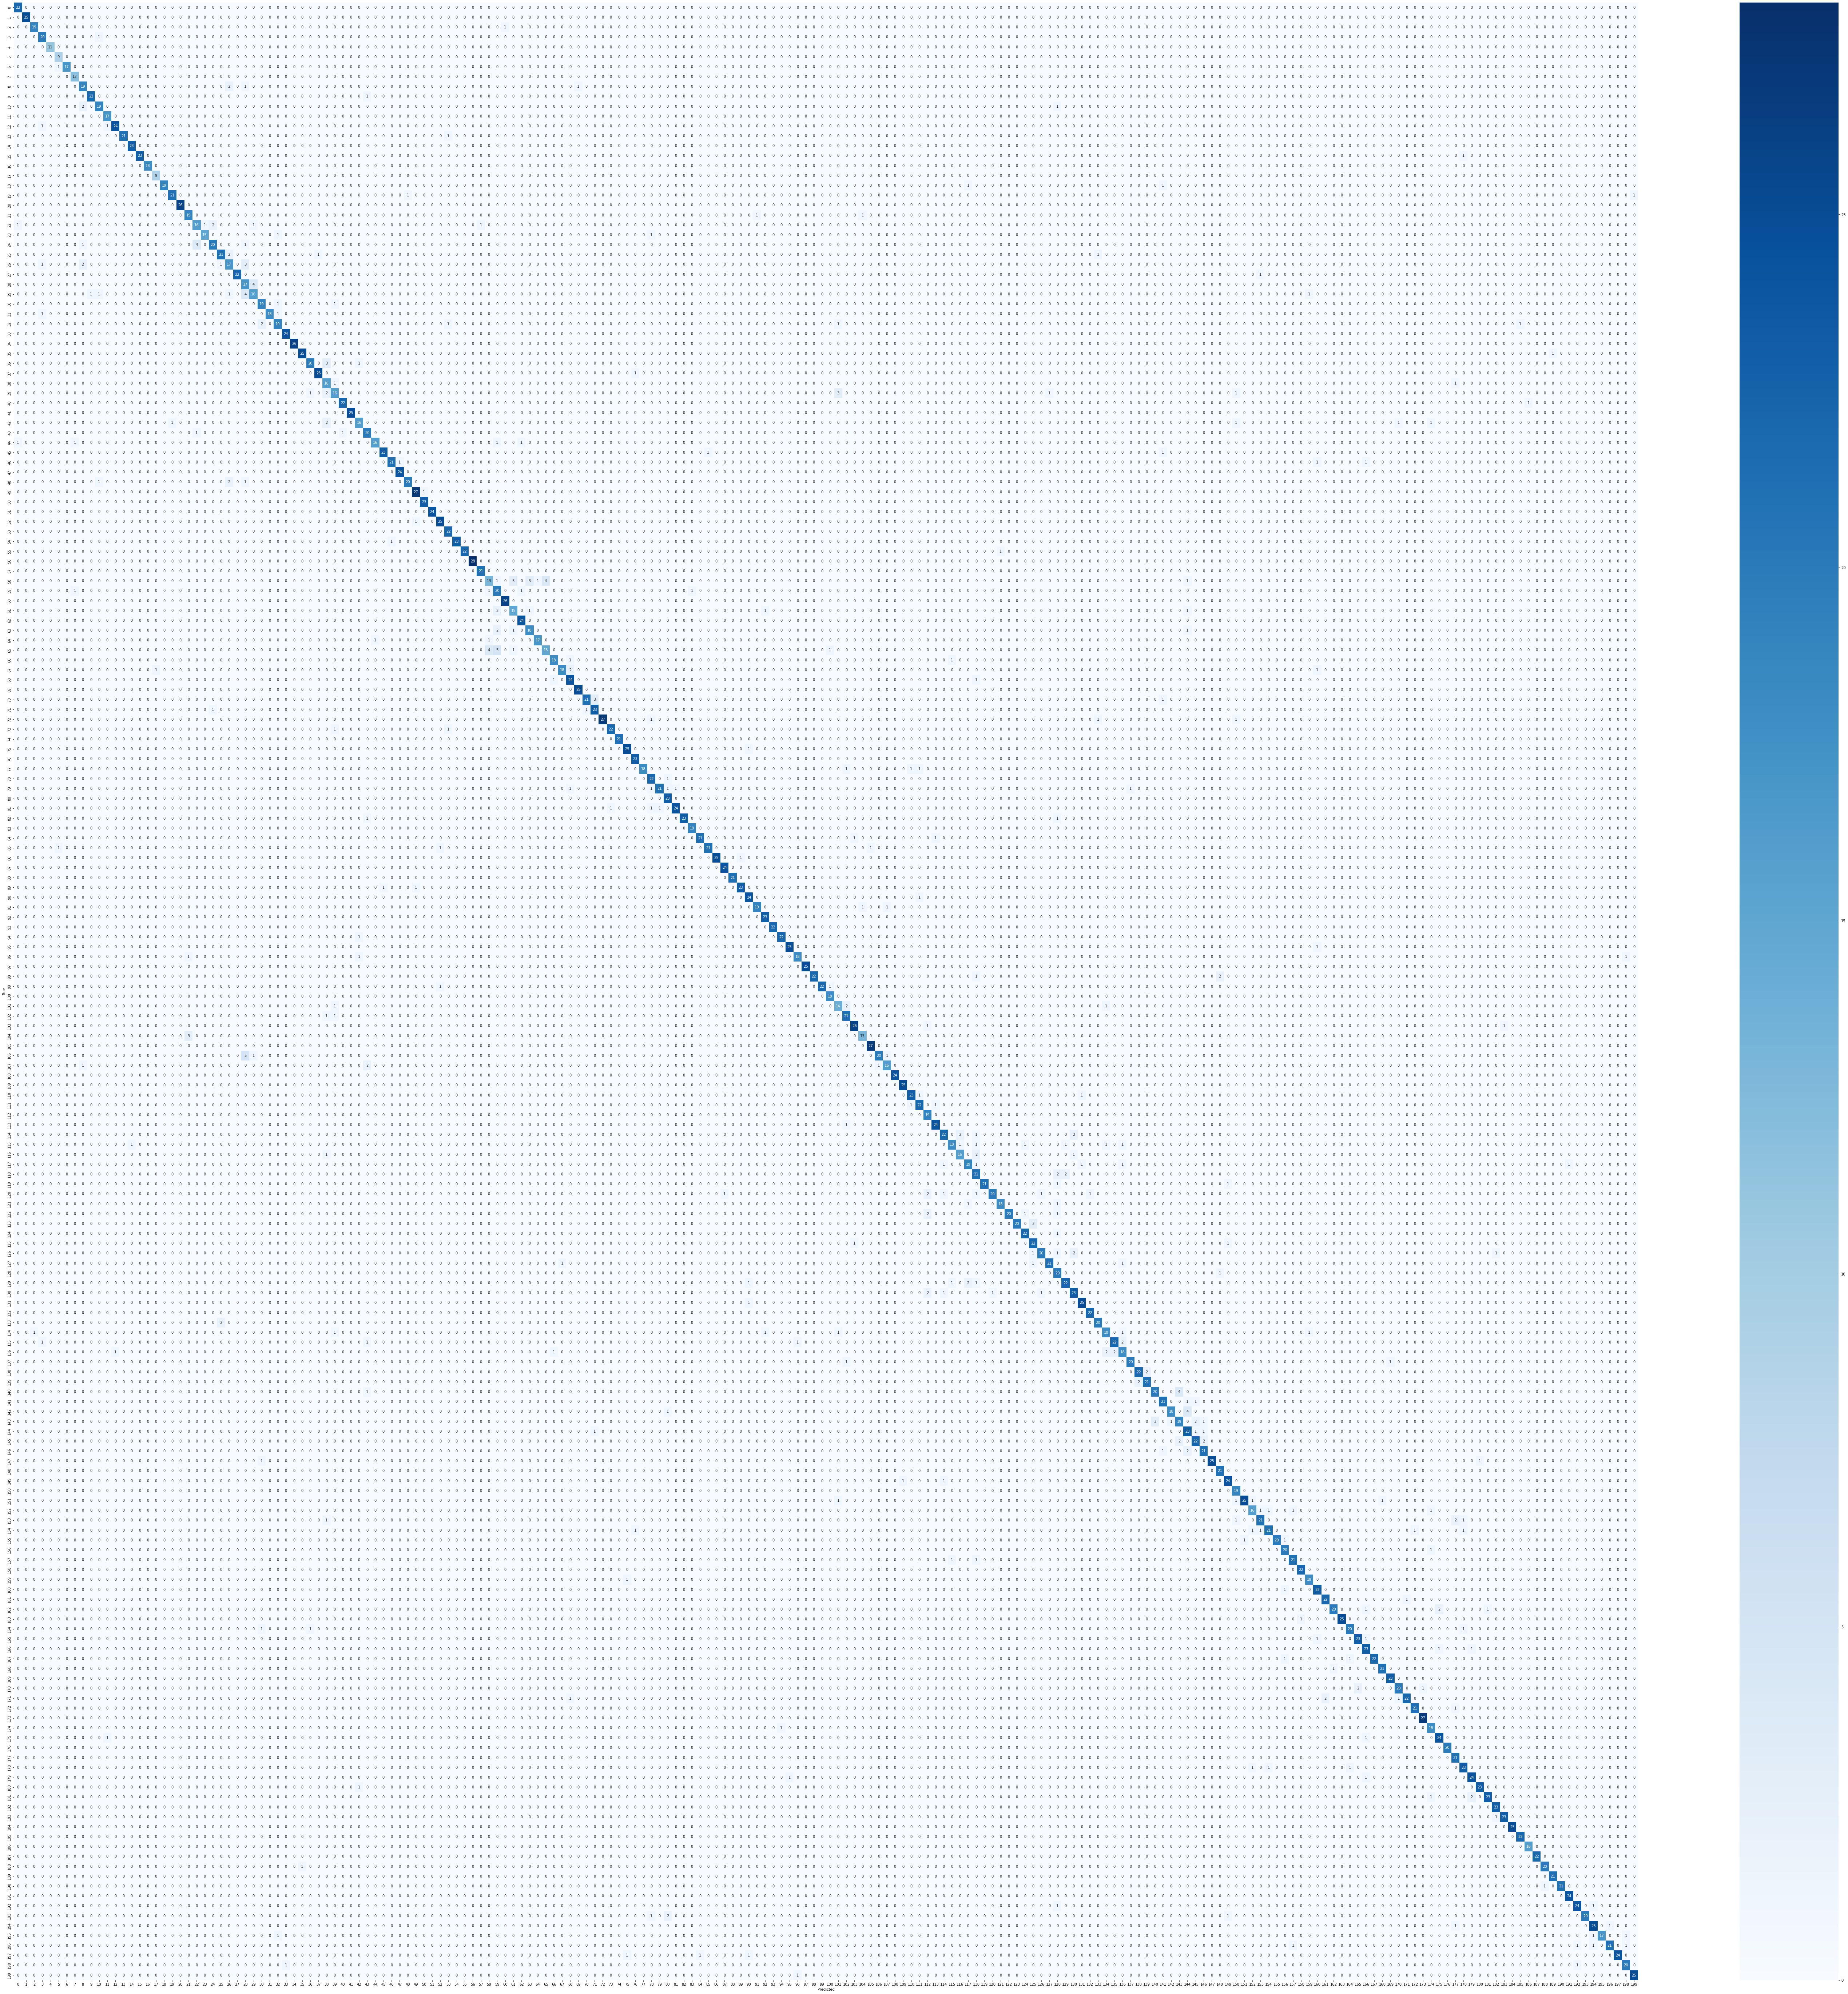

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(true_labels, predictions)

# Display as a heatmap
plt.figure(figsize=(100, 100))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


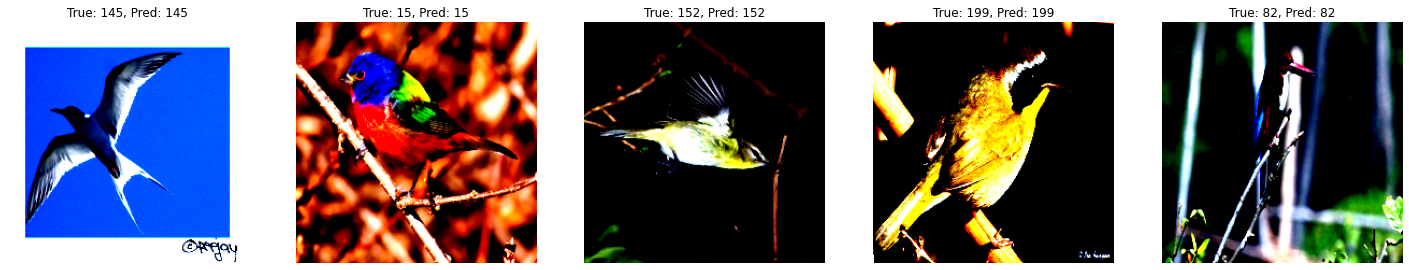

In [14]:
import matplotlib.pyplot as plt

# Get 5 random samples from the test set
samples, labels = next(iter(test_loader))
samples = samples[:5]
labels = labels[:5]

# Move to device
samples = samples.to(device)
labels = labels.to(device)

# Get predictions
model1.eval()
with torch.no_grad():
    outputs = model1(samples)
    _, preds = torch.max(outputs, 1)

# Move samples and labels back to CPU for displaying
samples = samples.cpu()
labels = labels.cpu()
preds = preds.cpu()

# Plot the images along with their true and predicted labels
fig, axs = plt.subplots(1, 5, figsize=(25, 5))
for i in range(5):
    axs[i].imshow(np.transpose(samples[i], (1, 2, 0)))  # Un-normalize here if necessary
    axs[i].set_title(f'True: {labels[i].item()}, Pred: {preds[i].item()}')
    axs[i].axis('off')
plt.show()